
# Phylo2MSClust



In [1]:
import matchms.filtering
from matchms.importing import load_from_mgf


def spectrum_processing(s):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = matchms.filtering.default_filters(s)
    s = matchms.filtering.add_parent_mass(s)
    s = matchms.filtering.normalize_intensities(s)
    s = matchms.filtering.reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5, n_max=500)
    s = matchms.filtering.select_by_mz(s, mz_from=0, mz_to=1000)
    s = matchms.filtering.require_minimum_number_of_peaks(s, n_required=10)
    return s

# Load data from MGF file and apply filters
spectrums = [spectrum_processing(s) for s in load_from_mgf("/Users/rtlortega/Documents/PhD/Datasets/pesticides.mgf")]

2025-10-29 07:46:40,387:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+K-2H]


In [2]:
# from matchms.importing import load_from_mgf


# # Load data from MGF file and apply filters
# spectrums = list(load_from_mgf("/Users/rtlortega/Documents/PhD/Datasets/pesticides.mgf"))

## Peak binning

In [3]:
import numpy as np

decimals = 1 # change
# Collect all rounded m/z values across spectra
all_bins = []
for spec in spectrums:
    binned_mz = np.round(spec.peaks.mz, decimals)
    all_bins.extend(binned_mz)

# Create global vocabulary of bins (rounded m/z centers)
global_bins = sorted(set(all_bins))# global vocabulary of bins

## Same spectra with the binned peaks

In [4]:
from matchms import Scores, Spectrum
import numpy as np


list_of_binned_spectra = []

for spec in spectrums:
    mz_rounded = np.round(spec.peaks.mz, decimals)

    spectrum = Spectrum(mz=mz_rounded,
                    intensities=spec.peaks.intensities,
                    metadata=spec.metadata)

    list_of_binned_spectra.append(spectrum)

In [5]:
from matchms import calculate_scores

#if use ML models change the conda to lattice normal environment (with spec2vec)
from ms2deepscore.models import load_model
from ms2deepscore import MS2DeepScore

from spec2vec import Spec2Vec
import gensim


ms2dp_model_file_name = "/Users/rtlortega/Documents/PhD/WP2/Code/LATTICE_Project/models/ms2deepscore_model.pt"
ms2dp_model = load_model(ms2dp_model_file_name)
ms2deepscore_similarity = MS2DeepScore(model=ms2dp_model)

s2v_model_file_name = "/Users/rtlortega/Documents/PhD/models/Spec2Vec/model_positive_mode/positive_train_data/150225_Spec2Vec_pos_CleanedLibraries.model" #change to your path

s2v_model = gensim.models.Word2Vec.load(s2v_model_file_name)

spec2vec_similarity = Spec2Vec(model=s2v_model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)


/Users/rtlortega/miniconda3/envs/WP2_test/lib/python3.9/site-packages/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = to

In [6]:
from collections import defaultdict, Counter
from itertools import combinations
import numpy as np
import pandas as pd

def calculate_boostrapping(list_of_binned_spectra, global_bins, B, k, spectra_similarity_metric): 
    # for later
    pair_sims_sum = defaultdict(float)
    pair_counts   = defaultdict(int)
    edge_support  = Counter()

    scan_ids = [s.get("scans") for s in list_of_binned_spectra]
    scan_to_idx = {sid: idx for idx, sid in enumerate(scan_ids)}

    for b in range(B):
        # sample P bins with replacement
        sampled_bin_indices = rng.integers(0, P, size=P)
        sampled_bins = [global_bins[i] for i in sampled_bin_indices]

        # build the resampled spectra
        spectra_boot = []
        for spec in list_of_binned_spectra:
            kept_mz = [mz for mz in spec.peaks.mz if mz in sampled_bins]
            kept_int = [spec.peaks.intensities[i] for i, mz in enumerate(spec.peaks.mz) if mz in sampled_bins]
            spec_copy = Spectrum(
                mz=np.array(kept_mz),
                intensities=np.array(kept_int),
                metadata=spec.metadata
            )
            spectra_boot.append(spec_copy)
        
        # skip empty set
        if len(spectra_boot) == 0:
            continue

        # compute similarities
        scores = calculate_scores(spectra_boot, spectra_boot, spectra_similarity_metric)

        sim_matrix = np.zeros((N, N), dtype=float)


        for ref_spec, query_spec, score_value in scores:
            i = scan_to_idx[ref_spec.get("scans")]
            j = scan_to_idx[query_spec.get("scans")]
            if i == j:
                continue
            sim_val = score_value[0]
            sim_matrix[i, j] = sim_matrix[j, i] = sim_val

            pair_sims_sum[(scan_ids[i], scan_ids[j])] += sim_val
            pair_counts[(scan_ids[i], scan_ids[j])] += 1


        # compute kNN for edge support
        for i in range(N):
            idx_sorted = np.argsort(sim_matrix[i])[::-1]
            knn_i = idx_sorted[1:k+1]  # skip self
            for j in knn_i:
                idx_sorted_j = np.argsort(sim_matrix[j])[::-1]
                knn_j = idx_sorted_j[1:k+1]
                if i in knn_j:
                    edge_support[tuple(sorted((scan_ids[i], scan_ids[j])))] += 1
        
        # mean similarity matrix
    mean_sim_mat = np.eye(N, dtype="float32")
    for (i, j), total_sim in pair_sims_sum.items():
        count = pair_counts[(i, j)]
        mean_sim_mat[scan_to_idx[i], scan_to_idx[j]] = mean_sim_mat[scan_to_idx[j], scan_to_idx[i]] = total_sim / count

    df_mean_sim = pd.DataFrame(mean_sim_mat, index=scan_ids, columns=scan_ids)

    # edge support matrix (fraction of bootstraps where edge was mutual with the kNN)
    edge_sup_mat = np.zeros((N, N), dtype="float32")
    for (i, j), cnt in edge_support.items():
        edge_sup_mat[scan_to_idx[i], scan_to_idx[j]] = edge_sup_mat[scan_to_idx[j], scan_to_idx[i]] = cnt / B

    df_edge_sup = pd.DataFrame(edge_sup_mat, index=scan_ids, columns=scan_ids)

    return df_mean_sim, df_edge_sup

In [7]:
# Customise!
N = len(list_of_binned_spectra)
P = len(global_bins)
rng = np.random.default_rng(42)
B = 100
k=5

In [8]:
df_mean_sim, df_edge_sup = calculate_boostrapping(list_of_binned_spectra, global_bins, B, k, spectra_similarity_metric=ms2deepscore_similarity)

76it [00:01, 68.64it/s] 
76it [00:00, 109.44it/s]
76it [00:00, 139.35it/s]
76it [00:00, 141.20it/s]
76it [00:00, 129.86it/s]
76it [00:00, 141.96it/s]
76it [00:00, 142.74it/s]
76it [00:00, 142.46it/s]
76it [00:00, 134.19it/s]
76it [00:00, 110.40it/s]
76it [00:00, 137.36it/s]
76it [00:00, 135.04it/s]
76it [00:00, 139.83it/s]
76it [00:00, 134.35it/s]
76it [00:00, 119.37it/s]
76it [00:00, 110.96it/s]
76it [00:00, 126.65it/s]
76it [00:00, 121.13it/s]
76it [00:00, 138.21it/s]
76it [00:00, 137.53it/s]
76it [00:00, 138.26it/s]
76it [00:00, 139.13it/s]
76it [00:00, 110.98it/s]
76it [00:00, 97.23it/s] 
76it [00:00, 117.23it/s]
76it [00:00, 117.13it/s]
76it [00:00, 137.70it/s]
76it [00:00, 138.37it/s]
76it [00:00, 138.43it/s]
76it [00:00, 129.94it/s]
76it [00:00, 114.50it/s]
76it [00:00, 131.56it/s]
76it [00:00, 137.65it/s]
76it [00:00, 141.45it/s]
76it [00:00, 143.08it/s]
76it [00:00, 142.01it/s]
76it [00:00, 139.02it/s]
76it [00:00, 143.56it/s]
76it [00:00, 142.17it/s]
76it [00:00, 142.21it/s]


## Lets visualise it

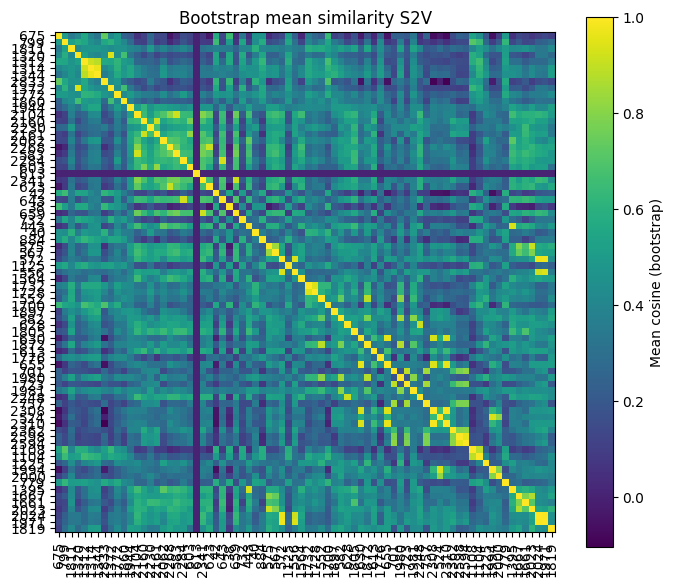

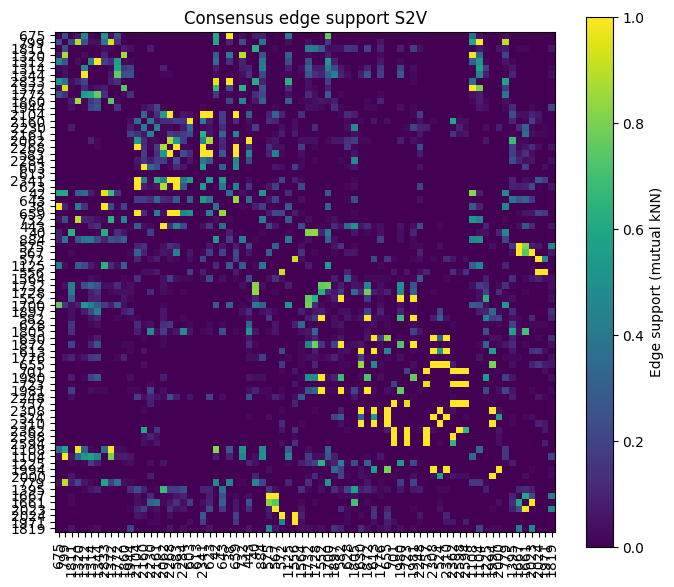

In [ ]:
import matplotlib.pyplot as plt

# use the same scan IDs that index your DataFrames
names = df_mean_sim.index.tolist()

plt.figure(figsize=(7,6))
plt.imshow(df_mean_sim.values, interpolation="nearest", cmap="viridis")
plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.colorbar(label="Mean cosine (bootstrap)")
plt.title("Bootstrap mean similarity MS2DP")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
plt.imshow(df_edge_sup.values, interpolation="nearest", cmap="viridis", vmin=0, vmax=1)
plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.colorbar(label="Edge support (mutual kNN)")
plt.title("Consensus edge support MS2DP")
plt.tight_layout()
plt.show()

